In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
CW_DATASET_PATH = "CW_dataset"

def load_train_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)

    return x_train_all, y_train_all

In [3]:
x_train, y_train = load_train_data()

In [4]:
x_train.shape


(9690, 2304)

In [5]:
y_train.shape

(9690, 1)

In [6]:
# x_train = np.asarray(x_train)

In [ ]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1],c=y, s=1) #s is the size of dots.
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca1 = pca.fit_transform(x_train, y_train)

plt.figure(figsize=(8, 4))
plot_clusters(X_pca1)
plt.show()

In [ ]:
# Created a list to store the labels that have less number of pictures
less_class_labels = [0, 5, 6, 7, 8, 9]

data_list = []
for index, row in x_train.iterrows():
    label = y_train.iloc[index, 0]
    image_data = row.values.reshape(48, 48)

    if label in less_class_labels:
        data_list.append((image_data, label))

subset_dataset = np.array(data_list, dtype=object)

print(subset_dataset.shape)

num_images_per_label = {label: np.sum(subset_dataset[:, 1] == label) for label in less_class_labels}

for label, num_images in num_images_per_label.items():
    print(f"Label {label}: {num_images} images")

In [ ]:
def add_noise(feature_vector, noise_level=0.01):
    noise = np.random.normal(0, noise_level, feature_vector.shape)
    noisy_vector = feature_vector + noise
    return noisy_vector

In [ ]:
def introduce_perturbations(feature_vector, perturbation_level=0.02):
    min_value = np.min(feature_vector)
    max_value = np.max(feature_vector)
    perturbations = np.random.uniform(-perturbation_level, perturbation_level, feature_vector.shape)
    perturbed_vector = feature_vector + perturbations * (max_value - min_value)
    return perturbed_vector

In [ ]:
from scipy.stats.mstats import winsorize
x_train = np.array(x_train)

# Winsorize the data (adjust percentiles as needed)
winsorized_data = winsorize(x_train, limits=[0.05, 0.05])

def normalise(images):
    preprocessed_images = []
    for image in images: 
        if(len(image.shape) == 3):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        
        if image.dtype != np.uint8:
            image = image.astype(np.uint8)

        adjusted = cv2.convertScaleAbs(image, alpha=1.7, beta = 90)
        enhanced_image = cv2.equalizeHist(adjusted)
        image = enhanced_image/255.0
        resize = cv2.resize(image, (48,48))

        preprocessed_images.append(resize)
    return  np.array(preprocessed_images)


x_train = normalise(x_train)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

In [ ]:
#NO
print(x_train.shape)
print(y_train.shape)

augmented_data = []
new_augmented_data = []
labels_for_train = []
for data, label in subset_dataset:
    noisy_vector = add_noise(data, noise_level=0.01)  
    perturbed_vector = introduce_perturbations(data, perturbation_level=0.02)  
    
        # Append the original and augmented data with their respective labels
    augmented_data.append((data, label))
    augmented_data.append((noisy_vector, label))
    augmented_data.append((perturbed_vector, label))

# Convert the appended data to a NumPy array
for image_vectors, label_col in augmented_data:
    new_augmented_data.append(image_vectors)
    labels_for_train.append(label_col)

new_augmented_data = np.array(new_augmented_data)
labels_for_train = np.array(labels_for_train)

new_labels = labels_for_train.reshape(-1, 1)

new_augmented_data = new_augmented_data.reshape(new_augmented_data.shape[0], -1)

print(new_augmented_data.shape)
print(new_labels.shape)
if new_augmented_data.shape[1] == x_train.shape[1]:
    x_train = np.vstack((x_train, new_augmented_data))
    y_train = np.concatenate((y_train, new_labels))
else:
    print("Number of columns in appended_data doesn't match x_train.")

print(x_train.shape)
print(y_train.shape)

In [ ]:
#NO
rotation_angle = 15
scale_factor = 1.2

rotated_images = []

for image in x_train:
    image = image.reshape(48, 48)  
    rotated_image = cv2.warpAffine(image, cv2.getRotationMatrix2D((image.shape[1] / 2, image.shape[0] / 2), rotation_angle, scale_factor), (image.shape[1], image.shape[0]))
    rotated_images.append(rotated_image)

x_train = np.asarray(rotated_images)

x_train = x_train.reshape(x_train.shape[0], -1)
x_train.shape

In [ ]:
#NO
from sklearn.preprocessing import StandardScaler
import cv2
import numpy as np

# Additional Pre processing
def preprocess_data(data):
    preprocessed_images = []
    
    for image in data:
        # Reshaping the image to its original shape
        image = image.reshape(48, 48)
        
        # Apply Gaussian blur to reduce noise
        blurred_image = cv2.GaussianBlur(image, (5, 5), 0)
        
        # Apply sharpening filter to enhance image details
        sharpened_image = cv2.filter2D(blurred_image, -1, np.array([[-1, -1, -1],
                                                                    [-1,  9, -1],
                                                                    [-1, -1, -1]]))
        
        # Standardize pixel values using StandardScaler
        scaler = StandardScaler()
        standardized_image = scaler.fit_transform(sharpened_image)
        
        # Append the preprocessed image to the list
        preprocessed_images.append(standardized_image)
    
    preprocessed_data = np.asarray(preprocessed_images)
    
    # Reshape the data back to the flattened format
    preprocessed_data = preprocessed_data.reshape(preprocessed_data.shape[0], -1)
    
    return preprocessed_data

x_train = preprocess_data(x_train)
print(x_train.shape)

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca2 = pca.fit_transform(x_train, y_train)

plt.figure(figsize=(8, 4))
plot_clusters(X_pca2)
plt.show()

# Hard Clustering

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
x_train_pca = pca.fit_transform(x_train)

# plt.figure(figsize=(8, 4))
# plt.title("K-Means Clustering")
# plot_clusters(X_pca, cluster_labels)
# plt.show()

## Hierarchical Clustering

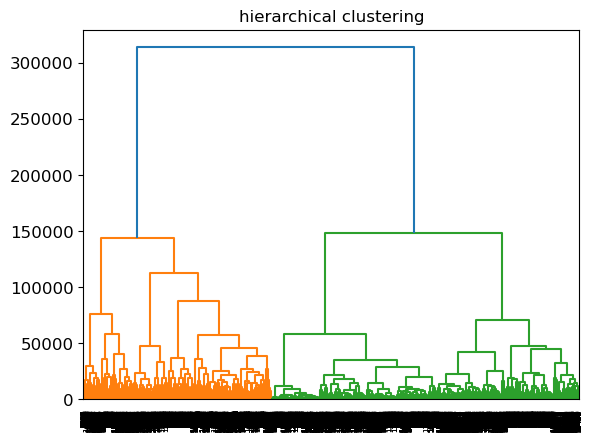

In [17]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

n_clusters=10
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(x_train)

linkage_matrix = linkage(x_train, method='ward')

dendrogram(linkage_matrix)
plt.title('hierarchical clustering')
plt.show()

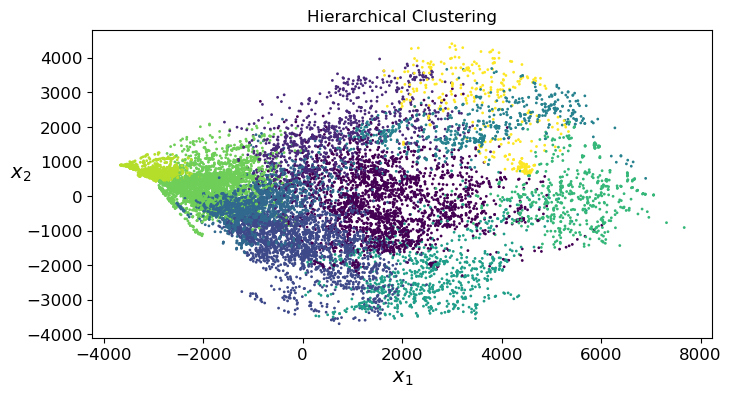

In [18]:
import matplotlib.pyplot as plt

# pca = PCA(n_components=0.95)
# x_train_pca = pca.fit_transform(x_train)

plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering")
plot_clusters(x_train_pca, agg_labels)
plt.show()


In [19]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(x_train_pca, agg_labels)
print("Silhouette Score = ", silhouette_scores)

Silhouette Score =  0.0869108084854132


Silhouette Score with t-SNE + K-Means =  0.30047765


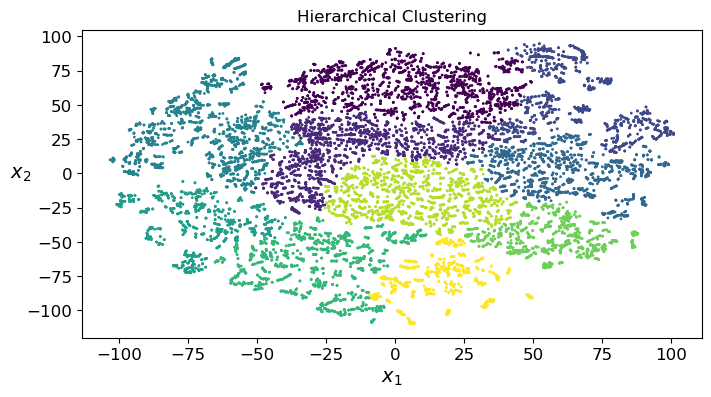

In [20]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
agg_clustering_tsne = AgglomerativeClustering(n_clusters=10)
agg_labels_tsne = agg_clustering_tsne.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, agg_labels_tsne)
print("Silhouette Score with t-SNE + K-Means = ", silhouette_scores_tsne)

plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering")
plot_clusters(x_train_tsne, agg_labels_tsne)
plt.show()

# CODE TO MOVE TO PART 2

## Hierarchical Clustering 

### PCA

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

n_clusters=10
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_labels = agg_clustering.fit_predict(X_pca)

linkage_matrix = linkage(X_pca, method='ward')

dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering with 10 clusters')
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering with 10 clusters")
plot_clusters(X_pca, agg_labels)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, agg_labels)
print("Silhouette Score = ", silhouette_scores)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)


agg_clustering_tsne = AgglomerativeClustering(n_clusters=10)
agg_labels_tsne = agg_clustering_tsne.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, agg_labels_tsne)
print("Silhouette Score with t-SNE + K-Means = ", silhouette_scores_tsne)

linkage_matrix = linkage(x_train_tsne, method='ward')

dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering with 10 clusters')
plt.show()

plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering with 10 clusters")
plot_clusters(x_train_tsne, agg_labels_tsne)
plt.show()

#### Hierarchical with 2 clusters

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

n_clusters=10
agg_clustering_2 = AgglomerativeClustering(n_clusters=2)
agg_labels_2 = agg_clustering_2.fit_predict(X_pca)

linkage_matrix_2 = linkage(X_pca, method='ward')

dendrogram(linkage_matrix_2)
plt.title('Hierarchical Clustering with 2 clusters')
plt.show()

In [ ]:
plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering with 2 clusters")
plot_clusters(X_pca, agg_labels_2)
plt.show()

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, agg_labels_2)
print("Silhouette Score = ", silhouette_scores)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
agg_clustering_tsne = AgglomerativeClustering(n_clusters=2)
agg_labels_tsne = agg_clustering_tsne.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, agg_labels_tsne)
print("Silhouette Score with t-SNE + Heirarchy = ", silhouette_scores_tsne)

linkage_matrix = linkage(x_train_tsne, method='ward')

dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering with 10 clusters')
plt.show()

plt.figure(figsize=(8, 4))
plt.title("Hierarchical Clustering with 2 clusters")
plot_clusters(x_train_tsne, agg_labels_tsne)
plt.show()

## Gaussian Mixture Models

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10)
gmm.fit(X_pca)

labels = gmm.predict(X_pca)

plot_clusters(X_pca, labels)


In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, labels)
print("Silhouette Score = ", silhouette_scores)

In [ ]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2)
gmm.fit(X_pca)

labels_2 = gmm.predict(X_pca)

plot_clusters(X_pca, labels_2)

In [ ]:
from sklearn.metrics import silhouette_score

silhouette_scores = silhouette_score(X_pca, labels_2)
print("Silhouette Score = ", silhouette_scores)

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
gmm = GaussianMixture(n_components=10)
gmm_labels_tsne = gmm.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, gmm_labels_tsne)
print("Silhouette Score with t-SNE + GMM = ", silhouette_scores_tsne)

plt.figure(figsize=(8, 4))
plt.title("GMM Clustering with 10 clusters")
plot_clusters(x_train_tsne, gmm_labels_tsne)
plt.show()

In [ ]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)

tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train_scaled)

# Now apply K-means clustering on the t-SNE processed data
gmm = GaussianMixture(n_components=2)
gmm_labels_tsne = gmm.fit_predict(x_train_tsne)

silhouette_scores_tsne = silhouette_score(x_train_tsne, gmm_labels_tsne)
print("Silhouette Score with t-SNE + GMM = ", silhouette_scores_tsne)

plt.figure(figsize=(8, 4))
plt.title("GMM Clustering with 2 clusters")
plot_clusters(x_train_tsne, gmm_labels_tsne)
plt.show()

## EXTRA STUFF

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 5, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

fig = plt.figure(figsize=(15, 4)) 

for i in range(2, 6): 
    gmm = mixture.GaussianMixture(n_components=i, covariance_type="full").fit(X_pca)
    plot_results(X_pca, gmm.predict(X_pca), gmm.means_, gmm.covariances_, i - 1, f"GMM with {i} components")

plt.tight_layout()
plt.show()

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 10, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

fig = plt.figure(figsize=(15, 4)) 

for i in range(2, 11): 
    gmm = mixture.GaussianMixture(n_components=i, covariance_type="full").fit(x_train_tsne)
    plot_results(x_train_tsne, gmm.predict(x_train_tsne), gmm.means_, gmm.covariances_, i - 1, f"GMM with {i} components")
    gmm_labels_tsne = gmm.fit_predict(x_train_tsne)
    silhouette_scores_tsne = silhouette_score(x_train_tsne, gmm_labels_tsne)
    print(f"Silhouette Score with t-SNE + GMM with {i} components = ", silhouette_scores_tsne)

plt.tight_layout()
plt.show()

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
from sklearn import mixture

color_iter = itertools.cycle(["navy", "c", "cornflowerblue", "gold", "darkorange"])

def plot_results(X, Y_, means, covariances, index, title):
    splot = plt.subplot(1, 10, 1 + index)
    for i, (mean, covar, color) in enumerate(zip(means, covariances, color_iter)):
        v, w = linalg.eigh(covar)
        v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
        u = w[0] / linalg.norm(w[0])

        if not np.any(Y_ == i):
            continue
        plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], 0.8, color=color)

        angle = np.arctan(u[1] / u[0])
        angle = 180.0 * angle / np.pi
        ell = plt.matplotlib.patches.Ellipse(mean, v[0], v[1], angle=180.0 + angle, color=color)
        ell.set_clip_box(splot.bbox)
        ell.set_alpha(0.5)
        splot.add_artist(ell)

    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)
    plt.xticks(())
    plt.yticks(())
    plt.title(title)

fig = plt.figure(figsize=(15, 4)) 

for i in range(2, 11): 
    agg = AgglomerativeClustering(n_clusters=i).fit(x_train_tsne)
    agg_labels_tsne = agg.fit_predict(x_train_tsne)
    plot_clusters(x_train_tsne, agg_labels_tsne)
    silhouette_scores_tsne = silhouette_score(x_train_tsne, agg_labels_tsne)
    print(f"Silhouette Score with t-SNE + GMM with {i} components = ", silhouette_scores_tsne)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(x_train) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = GaussianMixture(n_components=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(x_train_tsne)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(x_train_tsne, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(x_train_tsne, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(x_train_tsne[:, 0], x_train_tsne[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    
    centers = clusterer.means_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for Gaussian clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

# Accuracy

In [ ]:
from sklearn.metrics import accuracy_score

def accuracy(c_labels, X, y_train, k):
    y_train = np.asarray(y_train)
    kmeans = GaussianMixture(n_components=k, random_state=42)
    cl = kmeans.fit_predict(X)

    for i in range(k):
        c = {}
        for j in range(len(c_labels)):
            if i == c_labels[j]:
                ground_truth_label = int(y_train[j])
                if ground_truth_label in c:
                    c[ground_truth_label] += 1
                else:
                    c[ground_truth_label] = 1
        max_c = max(c, key=c.get)
        for l in range(len(c_labels)):
            if i == c_labels[l]:
                cl[l] = max_c

    accuracy = accuracy_score(y_train, cl)  # Compare with ground truth labels
    print(f"Clustering Accuracy: {accuracy}")
    return accuracy

In [ ]:
a1 = accuracy(gmm_labels_tsne, x_train_tsne, y_train, 10)
